# HW 7 
Luther Richardson  
CS688   
4-11-21

In [3]:
# import packages
import csv
import networkx as nx
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from cdlib import algorithms
import json

## Set up key functions 

In [50]:
# import the csv
def import_data(file_path):
    file = open(file_path)
    data = csv.reader(file)
    return data


# Setup the graph
def graph_config(data):
    graph = nx.Graph()
    line_cnt = 0
    for line in data:
        # clean up the input data
        text = str(line[0])
        clean_line = text.replace("''", "")
        a, b = clean_line.split("|")
        # add values to the graph
        a = int(a)
        b = int(b)
        graph.add_node(a)
        graph.add_node(b)
        # create an edge between the values
        graph.add_edge(a, b)
        # cutoff to limit size as needed
        line_cnt += 1
        if line_cnt > 100:
            break
    return graph


# utility function to get better scaling on nodes for pagerank/HITS
def weight_normalizer(value):
    return round(value * 50000)


def show_dijkstra_graph(graph, partition_weight, path):
    # draw the graph
    pos = nx.spring_layout(graph)
    """
    Alternate layouts:
    nx.spectral_layout(graph)
    nx.kamada_kawai_layout(graph)
    nx.circular_layout(graph)
    nx.spiral_layout(graph)
    """
    # adjust sizing based on viz type
    size = 2000
    
    # larger figure size
    plt.figure(1, figsize=(30, 30))
    
    # draw the nodes
    nx.draw_networkx_nodes(graph,
                           pos,
                           partition_weight.keys(),
                           node_size=size,
                           cmap=plt.cm.Reds,
                           node_color=list(partition_weight.values()))
    
    # draw the edges not in the mst in one color
    non_mst_edges = graph.edges() - path
    nx.draw_networkx_edges(graph, 
                           pos, 
                           edgelist=non_mst_edges, 
                           alpha=1,
                           edge_color='black', 
                           width=1)
    
    # draw the edges in the path in another
    nx.draw_networkx_edges(graph, 
                           pos, 
                           edgelist=path, 
                           alpha=1,
                           edge_color='r', 
                           width=1)
    
    # draw the labels
    nx.draw_networkx_labels(graph, pos)
    
    # show the plot
    plt.show()


def show_mst_graph(graph, mst):
    # draw the graph
    pos = nx.spring_layout(graph)
    """
    Alternate layouts:
    nx.spectral_layout(graph)
    nx.kamada_kawai_layout(graph)
    nx.circular_layout(graph)
    nx.spiral_layout(graph)
    """

    # adjust sizing based on viz type
    size = 2000
    
    # larger figure size
    plt.figure(1, figsize=(30, 30))
    
    # draw the nodes
    nx.draw_networkx_nodes(graph, 
                           pos, 
                           node_size=size, 
                           cmap=plt.cm.Reds)
    
    # draw the edges not in the mst in one color
    non_mst_edges = graph.edges() - mst.edges()
    nx.draw_networkx_edges(graph, 
                           pos, 
                           edgelist=non_mst_edges, 
                           alpha=1,
                           edge_color='black', 
                           width=1)

    # draw the edges in the mst in another
    nx.draw_networkx_edges(graph, 
                           pos, 
                           edgelist=mst.edges(), 
                           alpha=1,
                           edge_color='r', 
                           width=1)
    
    # draw the labels
    nx.draw_networkx_labels(graph,
                            pos)
    # show the plot
    plt.show()


# visualizes a graph with partition or weights
def show_graph(graph, partition_weight, viz_type='none'):
    # draw the graph
    pos = nx.spring_layout(graph)
    """
    Alternate layouts:
    nx.spectral_layout(graph)
    nx.kamada_kawai_layout(graph)
    nx.circular_layout(graph)
    nx.spiral_layout(graph)
    nx.spring_layout(graph)
    """
    # adjust sizing based on viz type
    size = 2000
    if viz_type == 'weighted':
        size = list(partition_weight.values())

    # larger figure size
    plt.figure(1, figsize=(30, 30))

    nx.draw_networkx_nodes(graph,
                           pos,
                           partition_weight.keys(),
                           node_size=size,
                           cmap=plt.cm.Reds,
                           node_color=list(partition_weight.values()))

    nx.draw_networkx_edges(graph,
                           pos,
                           alpha=0.5)

    nx.draw_networkx_labels(graph,
                            pos)

    plt.show()


# Page rank and HITS algorithm to order the graph nodes based on their importance. (4 points)
# If the graph is too large for your system use a subgraph.
# For example, the size of the node circle could be used to visualize the importance of a node in Page rank and HITS.
def page_rank(graph):
    print("Page Rank")
    pr = nx.pagerank(graph)
    print(f"Pagerank scores:\n{pr}")
    weights = {k: weight_normalizer(v) for k, v in pr.items()}
    show_graph(graph, weights, 'weighted')


def hits_rank(graph):
    print("HITS rank")
    hubs, authorities = nx.hits(graph, max_iter=1000, normalized=True)
    print(f"Hubs:\n{hubs}")
    print(f"Authorities:\n{authorities}")
    # normalize the values for visualization
    hub_weights = {k: weight_normalizer(v) for k, v in hubs.items()}
    authority_weights = {k: weight_normalizer(v) for k, v in hubs.items()}
    # visualize
    return graph,hub_weights,authority_weights

def show_hub_weights(graph,hub_weights):
    show_graph(graph, hub_weights, 'weighted')

def show_authority_weights(graph,authority_weights):
    show_graph(graph, authority_weights, 'weighted')

# Louvain and Leiden for community detection (3 points)
# Visualize the result (5 points).
# Community detection should be visualized as well.
def louvain(graph):
    print("Louvain")
    # compute the partition
    partition = community_louvain.best_partition(graph)
    print(f"Partition:\n{partition}")
    # draw the graph
    show_graph(graph, partition)


def leiden(graph):
    print("Leiden")
    # run leiden
    partition = algorithms.leiden(graph)
    # convert to match the louvain partition format - must be dict
    partition = leiden_partition_adapter(partition.to_json())
    print(f"Partition: {partition}")
    # draw the graph
    show_graph(graph, partition)


# converts output from leiden algo into dict format for visualization
def leiden_partition_adapter(partition):
    # convert to JSON
    partition = json.loads(partition)
    new_partition_format = {}
    i = 0
    # Loop through communities and add to dict
    for item in partition['communities']:
        for value in item:
            new_partition_format.update({value: i})
        i += 1
    return new_partition_format


# used only for dijkstra's shortest path
def create_partition(graph, path):
    # Assign group to items in the path for visual
    partition = {}
    for item in graph:
        group = 1
        if item in path:
            group = 2
        partition.update({item: group})
    return partition


# Dijkstra to find the shortest path in the graph.
# Since the graph is large you can create a smaller file and work on the smaller graph. (1 point)
def shortest_path(graph, from_node, to_node):
    print("Dijkstra's Shortest Path")
    # calculate the shortest path
    path = nx.dijkstra_path(graph, from_node, to_node)
    # Assign group to items in the path for visual
    partition = create_partition(graph, path)
    print(f"Shortest path:\n{path}")
    print(f"Partition:\n{partition}")
    path_edges = []
    i = 0
    for value in path:
        # don't go outside the index of the path
        if i == len(path) - 1:
            break
        # build a list of tuples
        path_edges.append((value, path[i + 1]))
        # iterate
        i += 1
    show_dijkstra_graph(graph, partition, path_edges)


# Prim and Kruskal to find the MST from two arbitrary nodes one will be source one node will be target (2 points).
def prim_mst(graph):
    print("Prim MST")
    mst = nx.minimum_spanning_tree(graph, algorithm='prim')
    print(f"Graph edges:\n{graph.edges()}")
    print(f"MST edges:\n{mst.edges}")
    print(f"Edges not part of MST:\n{graph.edges - mst.edges}")

    show_mst_graph(graph, mst)


def kruskal_mst(graph):
    print("Kruskal MST")
    mst = nx.minimum_spanning_tree(graph, algorithm='kruskal')
    print(f"Graph edges:\n{graph.edges()}")
    print(f"MST edges:\n{mst.edges}")
    print(f"Edges not part of MST:\n{graph.edges - mst.edges}")
    show_mst_graph(graph, mst)

## Import the data

In [12]:
data = import_data("person_knows_person.csv")
graph = graph_config(data)

Kruskal MST
Graph edges:
[(38, 956), (38, 962), (38, 941), (38, 74), (38, 36), (38, 53), (38, 48), (38, 29), (38, 46), (38, 40), (38, 60), (38, 31), (38, 41), (38, 6), (38, 4), (38, 547), (38, 832), (38, 129), (38, 915), (38, 921), (38, 507), (38, 501), (38, 839), (38, 99), (38, 452), (38, 457), (38, 453), (38, 131), (38, 462), (38, 416), (38, 414), (38, 417), (38, 415), (38, 109), (38, 119), (38, 70), (38, 361), (38, 604), (38, 69), (38, 422), (38, 47), (38, 378), (38, 643), (38, 592), (38, 576), (38, 606), (38, 724), (38, 672), (38, 711), (38, 609), (38, 590), (38, 305), (38, 441), (38, 519), (38, 480), (38, 498), (38, 896), (38, 236), (38, 134), (38, 132), (38, 429), (38, 146), (38, 145), (38, 98), (38, 169), (38, 102), (38, 123), (38, 766), (38, 492), (38, 229), (38, 328), (38, 207), (38, 334), (38, 534), (38, 347), (38, 303), (38, 977), (38, 75), (38, 884), (38, 336), (38, 688), (38, 135), (956, 941), (962, 941), (941, 534), (941, 481), (941, 510), (941, 954), (941, 965), (941, 92

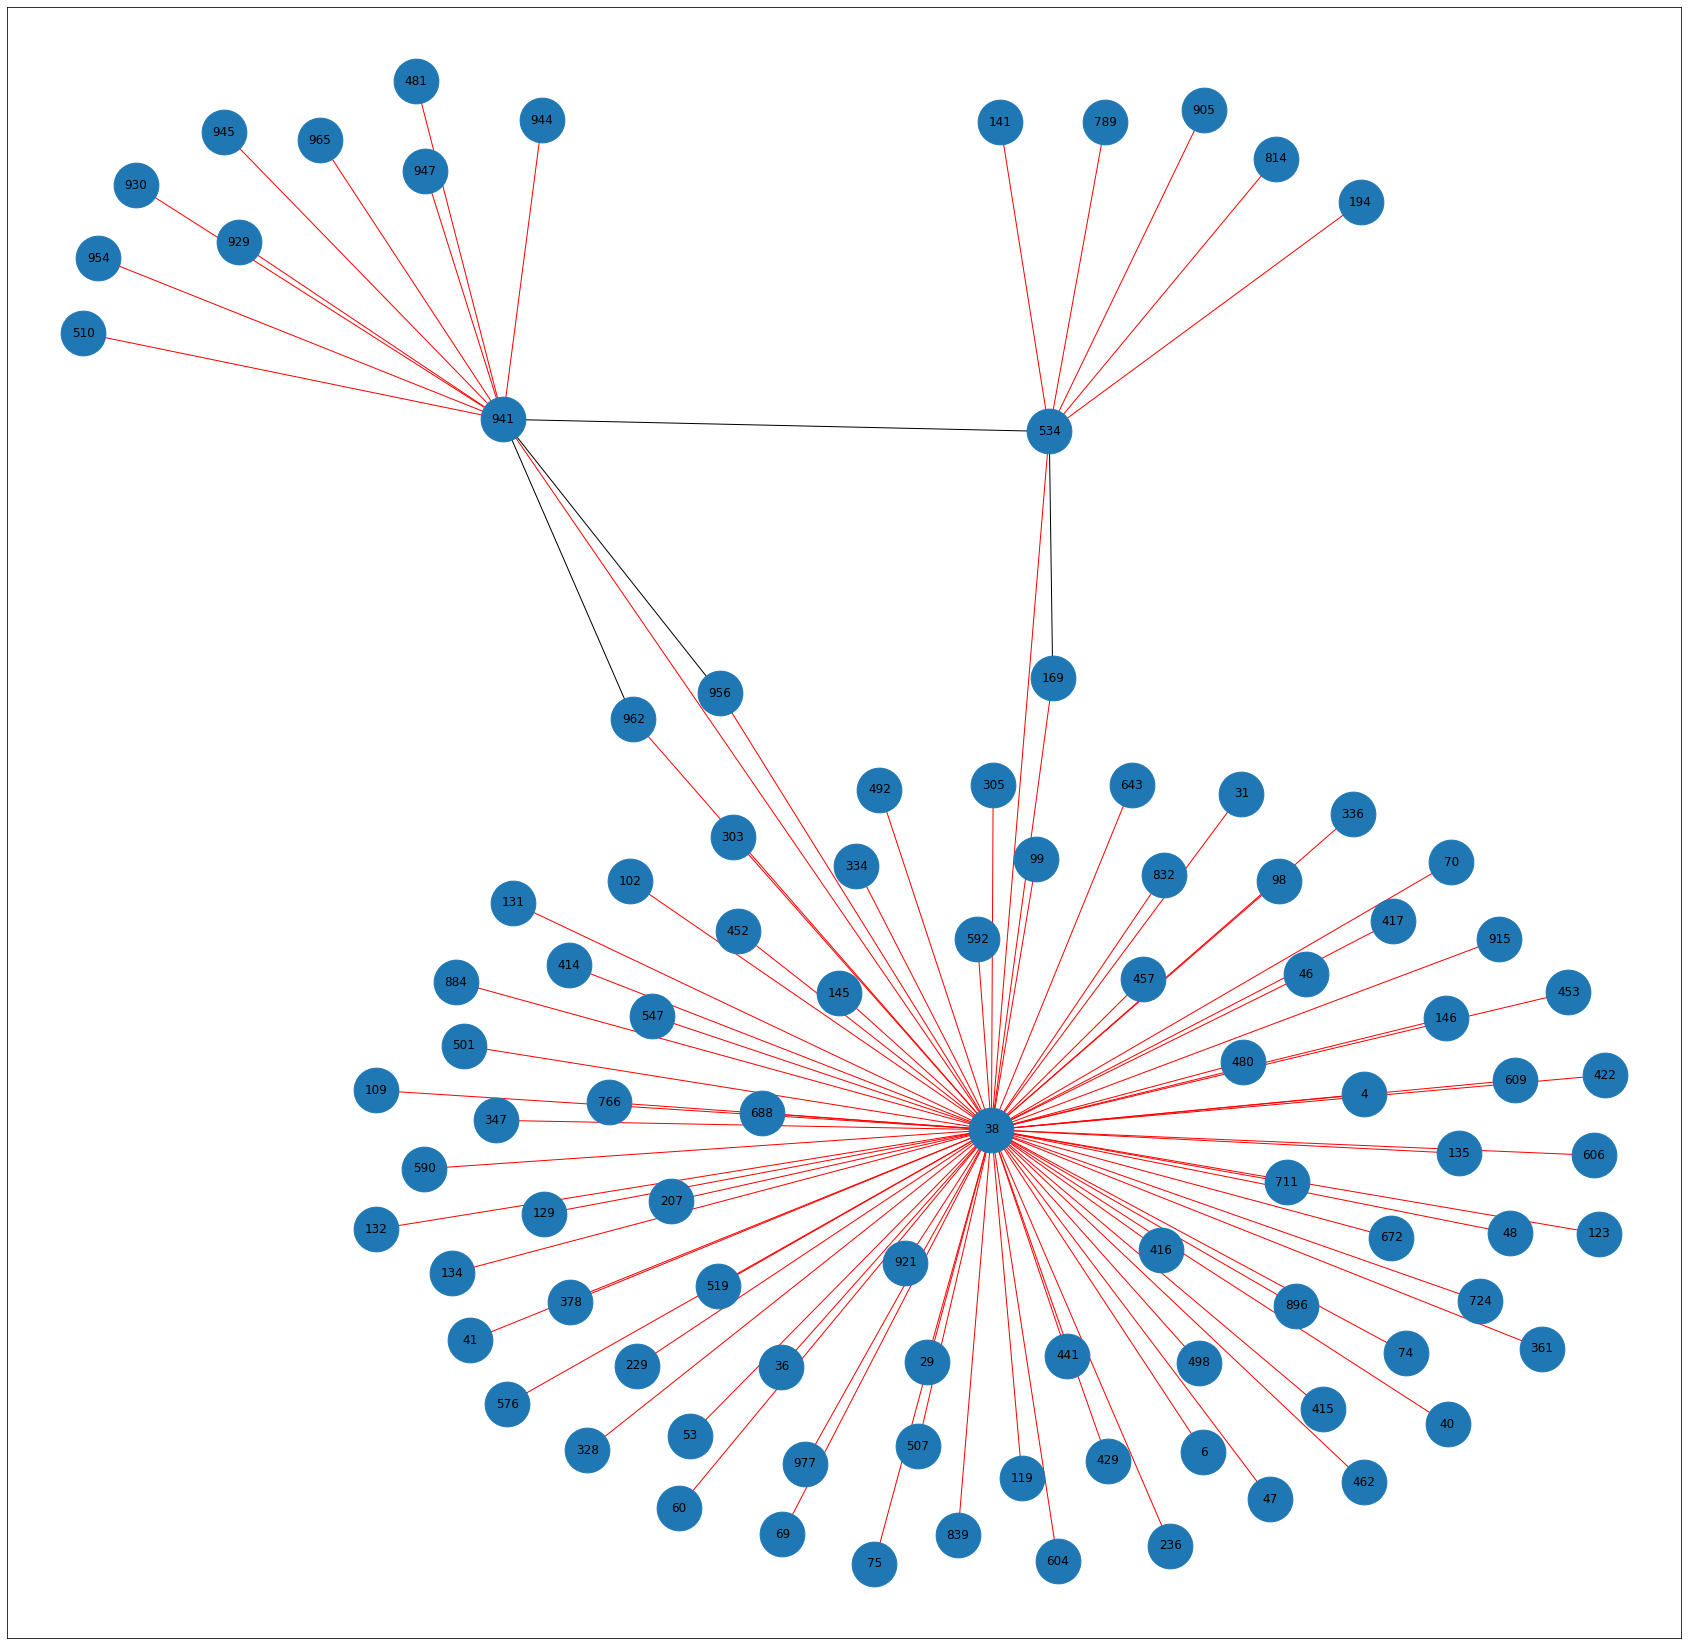

In [45]:
# MST using Kruskal's
kruskal_mst(graph)

Prim MST
Graph edges:
[(38, 956), (38, 962), (38, 941), (38, 74), (38, 36), (38, 53), (38, 48), (38, 29), (38, 46), (38, 40), (38, 60), (38, 31), (38, 41), (38, 6), (38, 4), (38, 547), (38, 832), (38, 129), (38, 915), (38, 921), (38, 507), (38, 501), (38, 839), (38, 99), (38, 452), (38, 457), (38, 453), (38, 131), (38, 462), (38, 416), (38, 414), (38, 417), (38, 415), (38, 109), (38, 119), (38, 70), (38, 361), (38, 604), (38, 69), (38, 422), (38, 47), (38, 378), (38, 643), (38, 592), (38, 576), (38, 606), (38, 724), (38, 672), (38, 711), (38, 609), (38, 590), (38, 305), (38, 441), (38, 519), (38, 480), (38, 498), (38, 896), (38, 236), (38, 134), (38, 132), (38, 429), (38, 146), (38, 145), (38, 98), (38, 169), (38, 102), (38, 123), (38, 766), (38, 492), (38, 229), (38, 328), (38, 207), (38, 334), (38, 534), (38, 347), (38, 303), (38, 977), (38, 75), (38, 884), (38, 336), (38, 688), (38, 135), (956, 941), (962, 941), (941, 534), (941, 481), (941, 510), (941, 954), (941, 965), (941, 929),

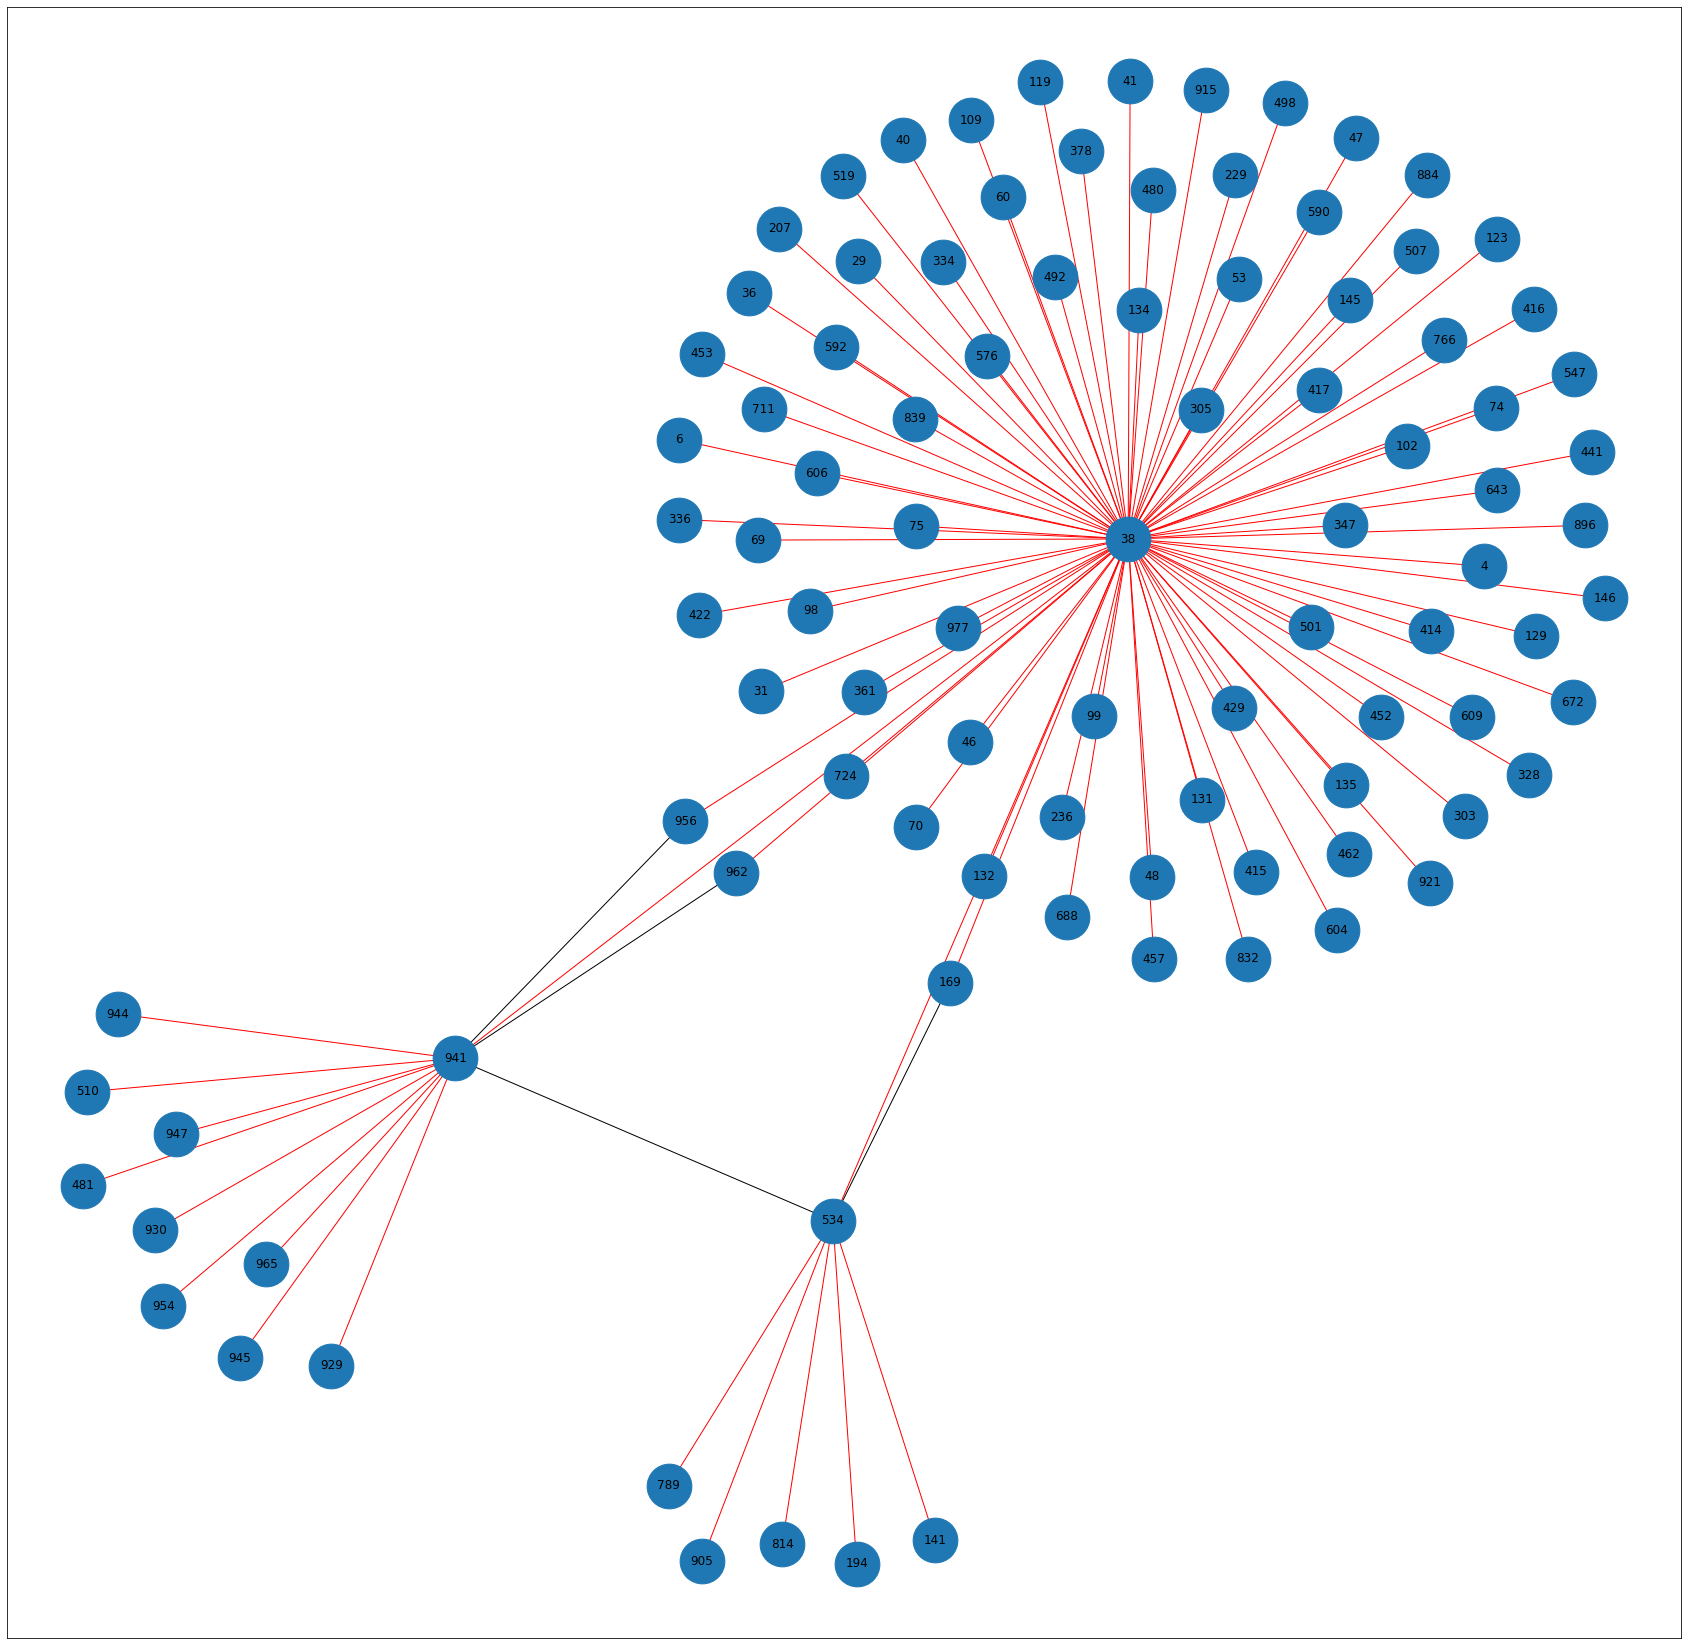

In [46]:
# MST using Prim's
prim_mst(graph)

Dijkstra's Shortest Path
Shortest path:
[905, 534, 38, 592]
Partition:
{38: 2, 956: 1, 962: 1, 941: 1, 74: 1, 36: 1, 53: 1, 48: 1, 29: 1, 46: 1, 40: 1, 60: 1, 31: 1, 41: 1, 6: 1, 4: 1, 547: 1, 832: 1, 129: 1, 915: 1, 921: 1, 507: 1, 501: 1, 839: 1, 99: 1, 452: 1, 457: 1, 453: 1, 131: 1, 462: 1, 416: 1, 414: 1, 417: 1, 415: 1, 109: 1, 119: 1, 70: 1, 361: 1, 604: 1, 69: 1, 422: 1, 47: 1, 378: 1, 643: 1, 592: 2, 576: 1, 606: 1, 724: 1, 672: 1, 711: 1, 609: 1, 590: 1, 305: 1, 441: 1, 519: 1, 480: 1, 498: 1, 896: 1, 236: 1, 134: 1, 132: 1, 429: 1, 146: 1, 145: 1, 98: 1, 169: 1, 102: 1, 123: 1, 766: 1, 492: 1, 229: 1, 328: 1, 207: 1, 334: 1, 534: 2, 347: 1, 303: 1, 977: 1, 75: 1, 884: 1, 336: 1, 688: 1, 135: 1, 141: 1, 905: 2, 789: 1, 814: 1, 194: 1, 481: 1, 510: 1, 954: 1, 965: 1, 929: 1, 930: 1, 947: 1, 945: 1, 944: 1}


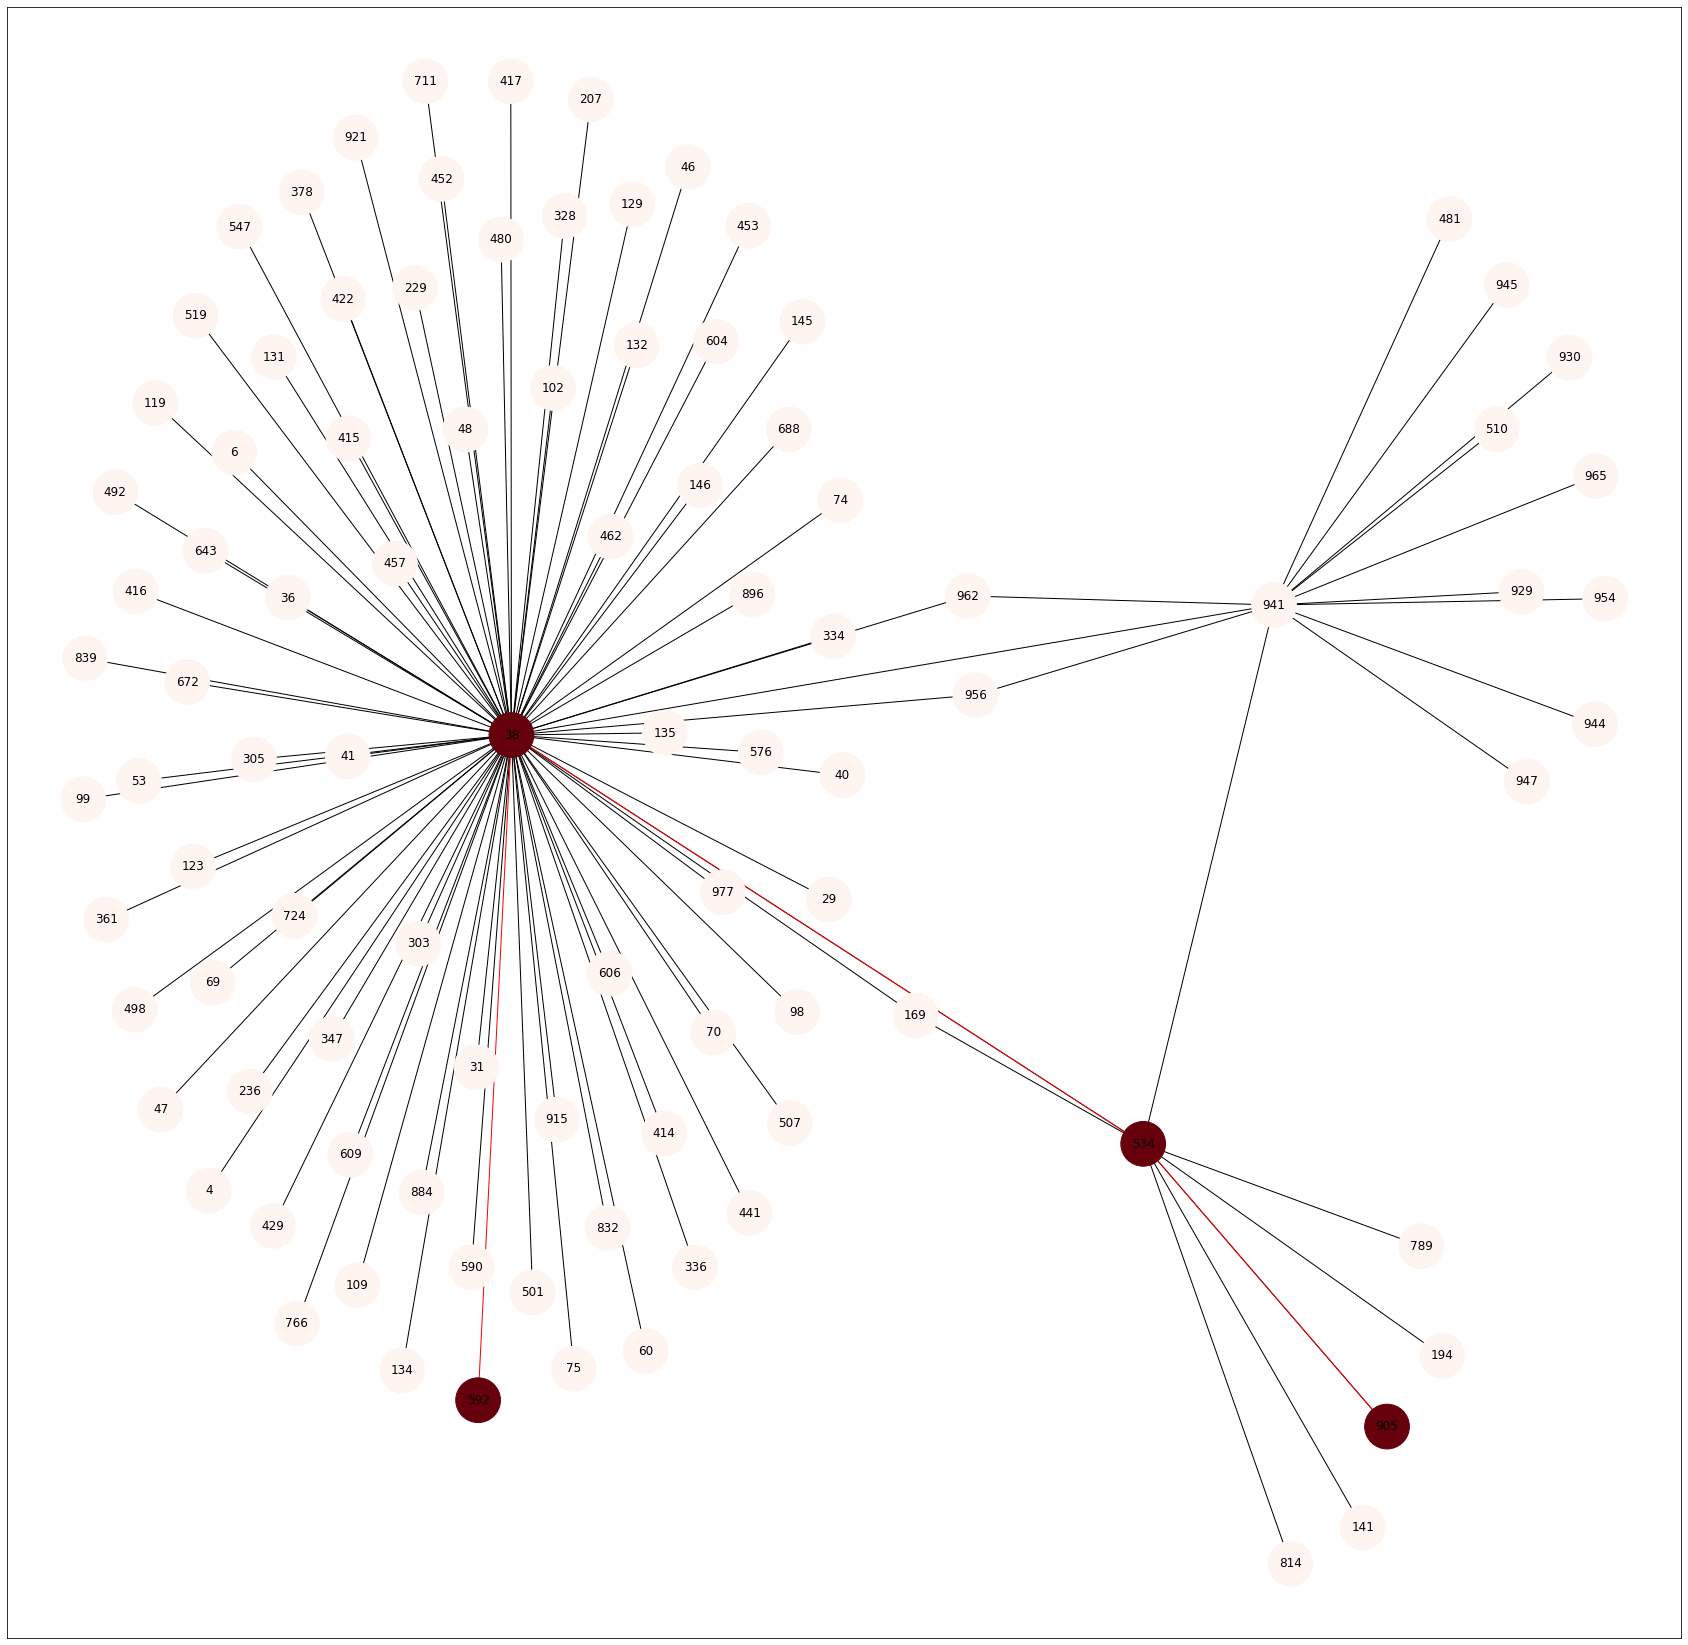

In [47]:
# Dijkstra's Shortest path
shortest_path(graph, 905, 592)

Page Rank
Pagerank scores:
{38: 0.380193130048483, 956: 0.009288615406141815, 962: 0.009288615406141815, 941: 0.058128739302860805, 74: 0.005487839641416921, 36: 0.005487839641416921, 53: 0.005487839641416921, 48: 0.005487839641416921, 29: 0.005487839641416921, 46: 0.005487839641416921, 40: 0.005487839641416921, 60: 0.005487839641416921, 31: 0.005487839641416921, 41: 0.005487839641416921, 6: 0.005487839641416921, 4: 0.005487839641416921, 547: 0.005487839641416921, 832: 0.005487839641416921, 129: 0.005487839641416921, 915: 0.005487839641416921, 921: 0.005487839641416921, 507: 0.005487839641416921, 501: 0.005487839641416921, 839: 0.005487839641416921, 99: 0.005487839641416921, 452: 0.005487839641416921, 457: 0.005487839641416921, 453: 0.005487839641416921, 131: 0.005487839641416921, 462: 0.005487839641416921, 416: 0.005487839641416921, 414: 0.005487839641416921, 417: 0.005487839641416921, 415: 0.005487839641416921, 109: 0.005487839641416921, 119: 0.005487839641416921, 70: 0.0054878396414

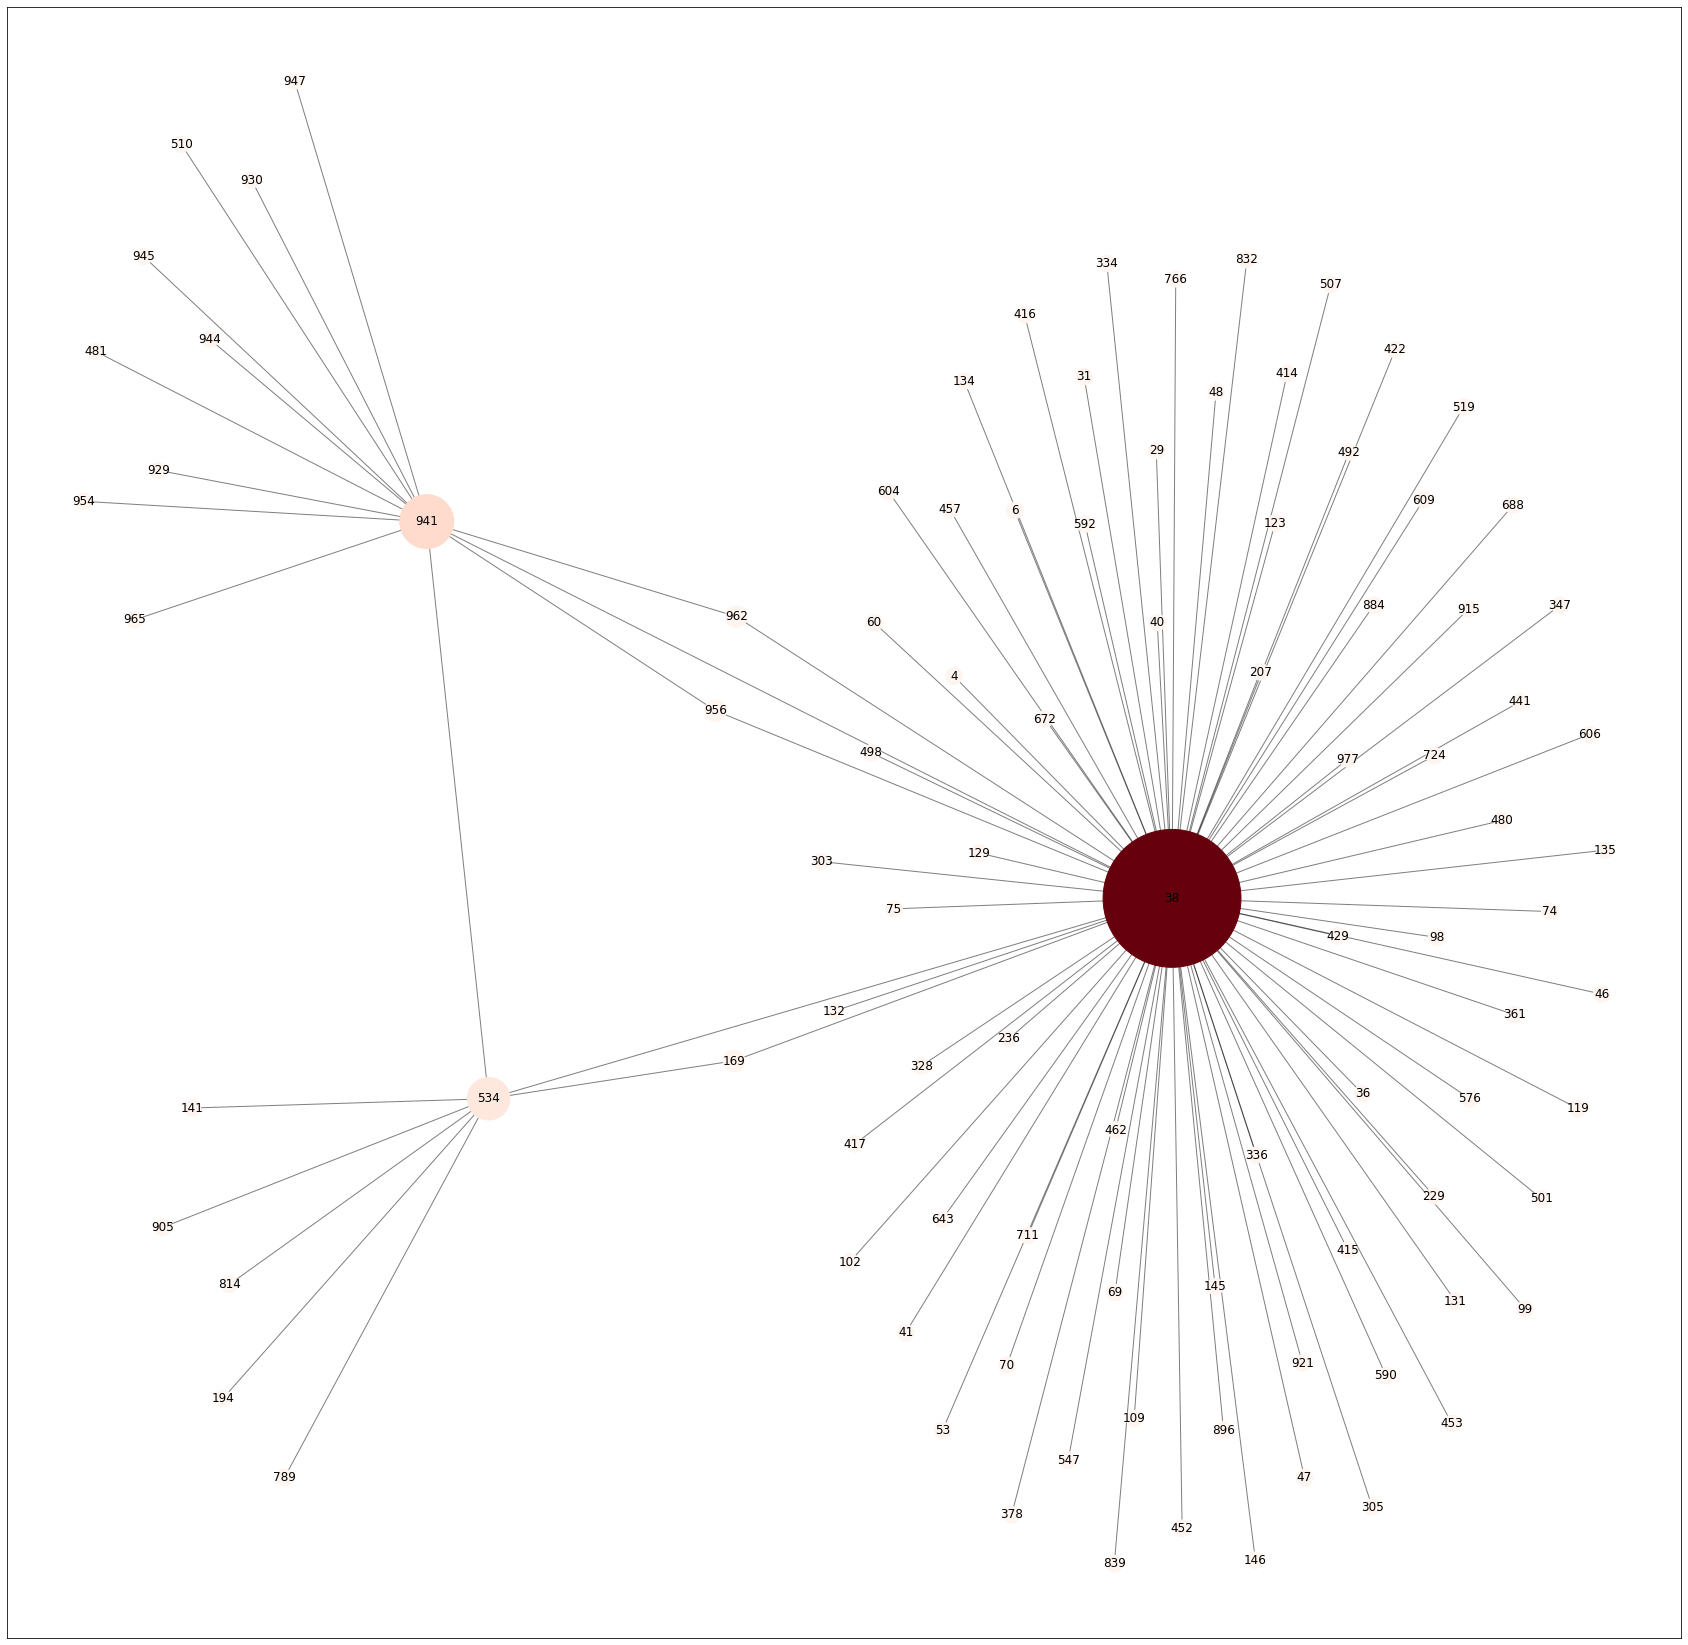

In [48]:
# Page rank
page_rank(graph)

In [51]:
# HITS algorithm
graph,hub_weights,authority_weights = hits_rank(graph)

HITS rank
Hubs:
{38: 0.0962611160169077, 956: 0.012357401006177226, 962: 0.012357401006177226, 941: 0.016629293714725636, 74: 0.01053709722621479, 36: 0.01053709722621479, 53: 0.01053709722621479, 48: 0.01053709722621479, 29: 0.01053709722621479, 46: 0.01053709722621479, 40: 0.01053709722621479, 60: 0.01053709722621479, 31: 0.01053709722621479, 41: 0.01053709722621479, 6: 0.01053709722621479, 4: 0.01053709722621479, 547: 0.01053709722621479, 832: 0.01053709722621479, 129: 0.01053709722621479, 915: 0.01053709722621479, 921: 0.01053709722621479, 507: 0.01053709722621479, 501: 0.01053709722621479, 839: 0.01053709722621479, 99: 0.01053709722621479, 452: 0.01053709722621479, 457: 0.01053709722621479, 453: 0.01053709722621479, 131: 0.01053709722621479, 462: 0.01053709722621479, 416: 0.01053709722621479, 414: 0.01053709722621479, 417: 0.01053709722621479, 415: 0.01053709722621479, 109: 0.01053709722621479, 119: 0.01053709722621479, 70: 0.01053709722621479, 361: 0.01053709722621479, 604: 0.010

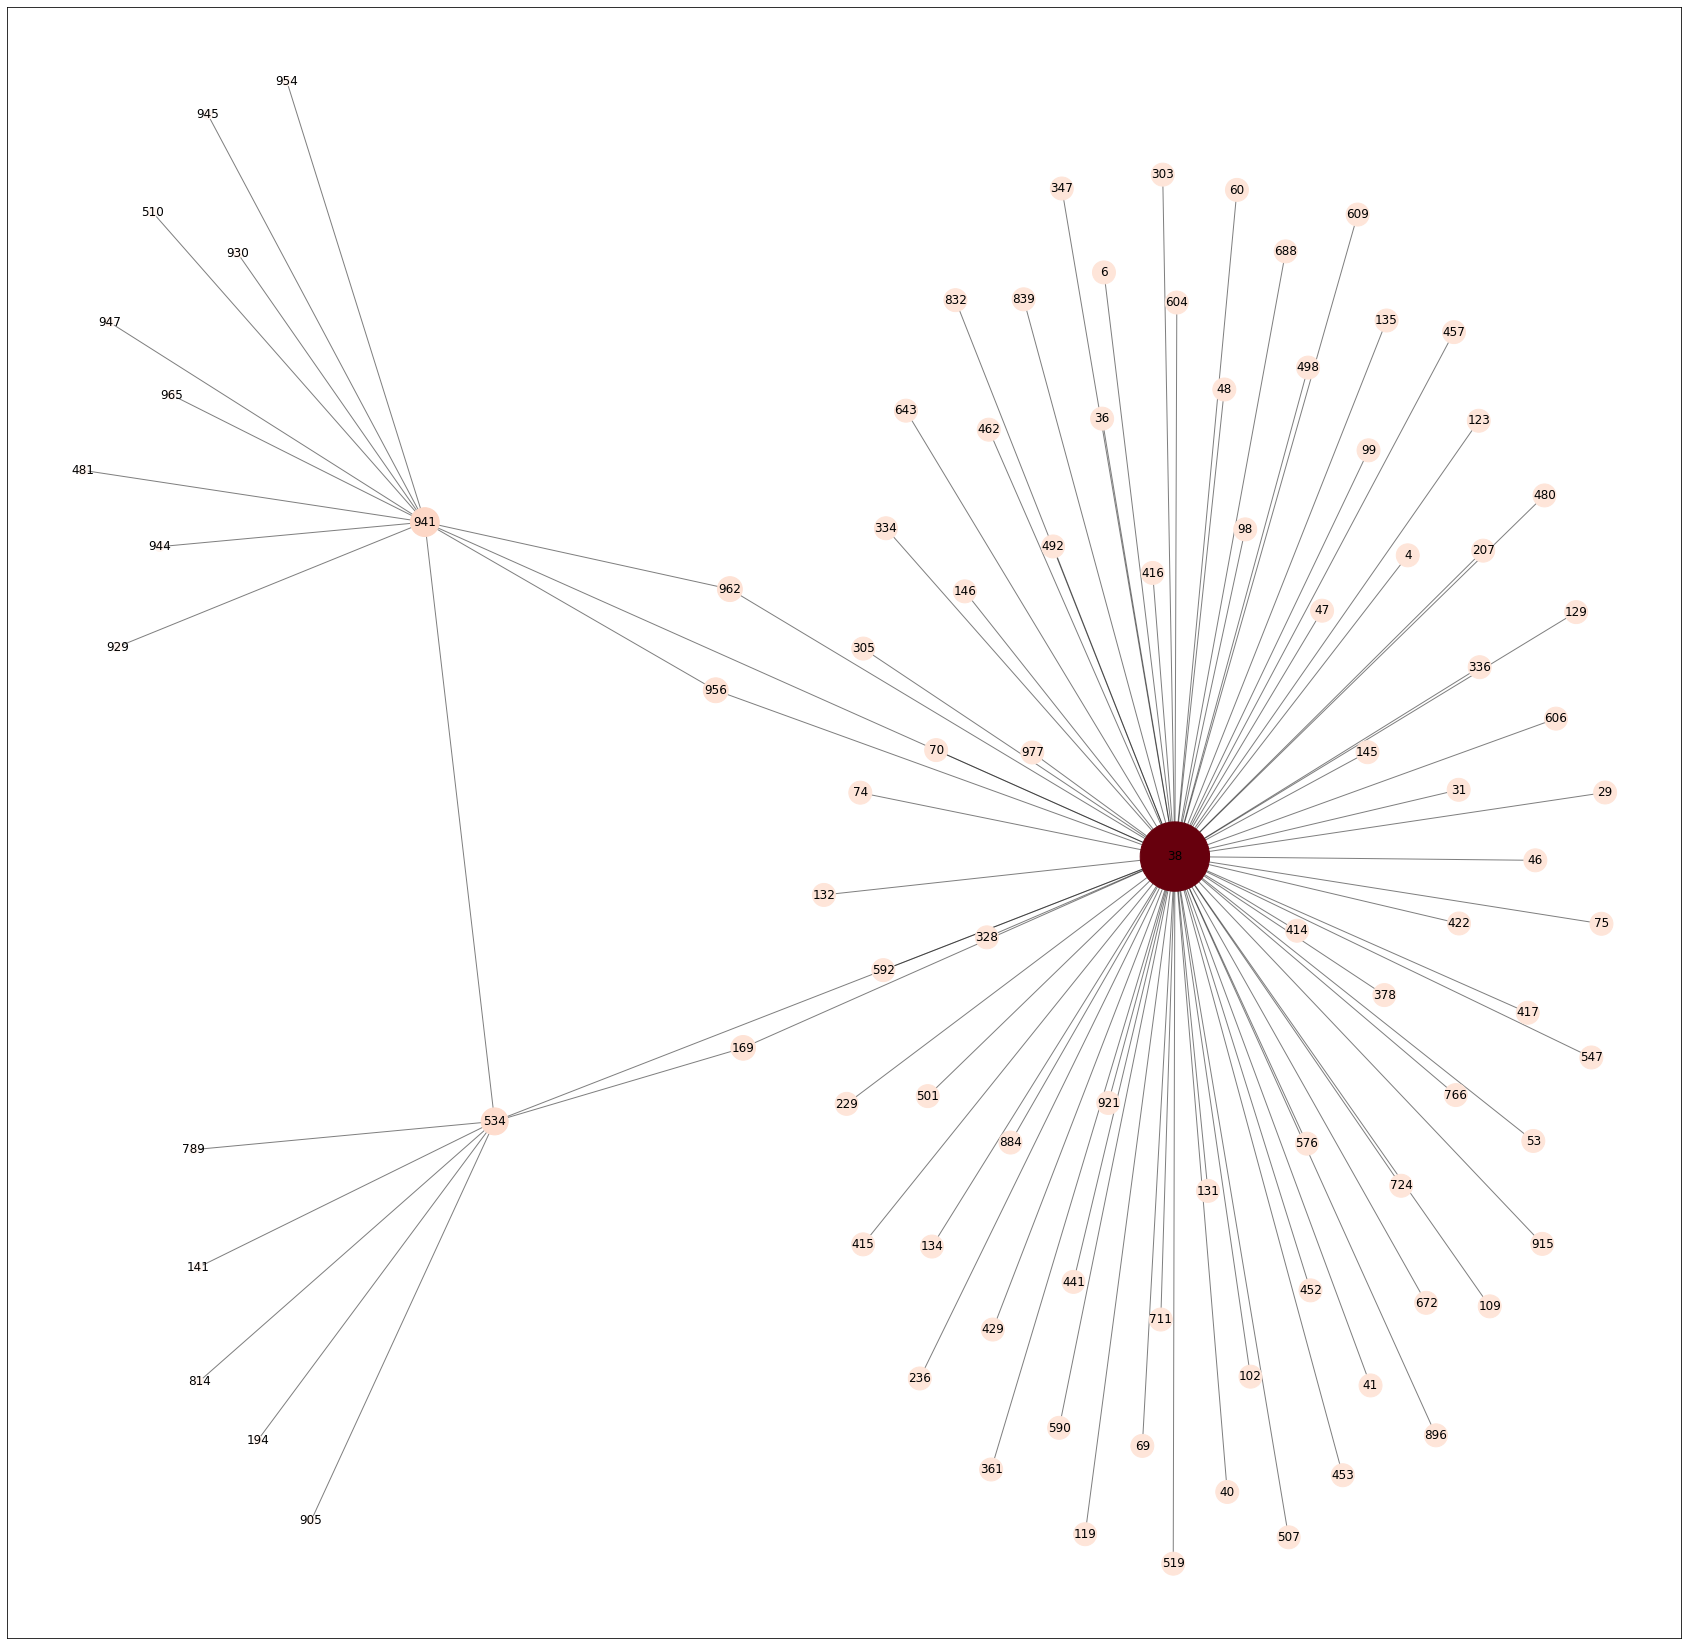

In [52]:
# HITS Hubs
show_hub_weights(graph,hub_weights)

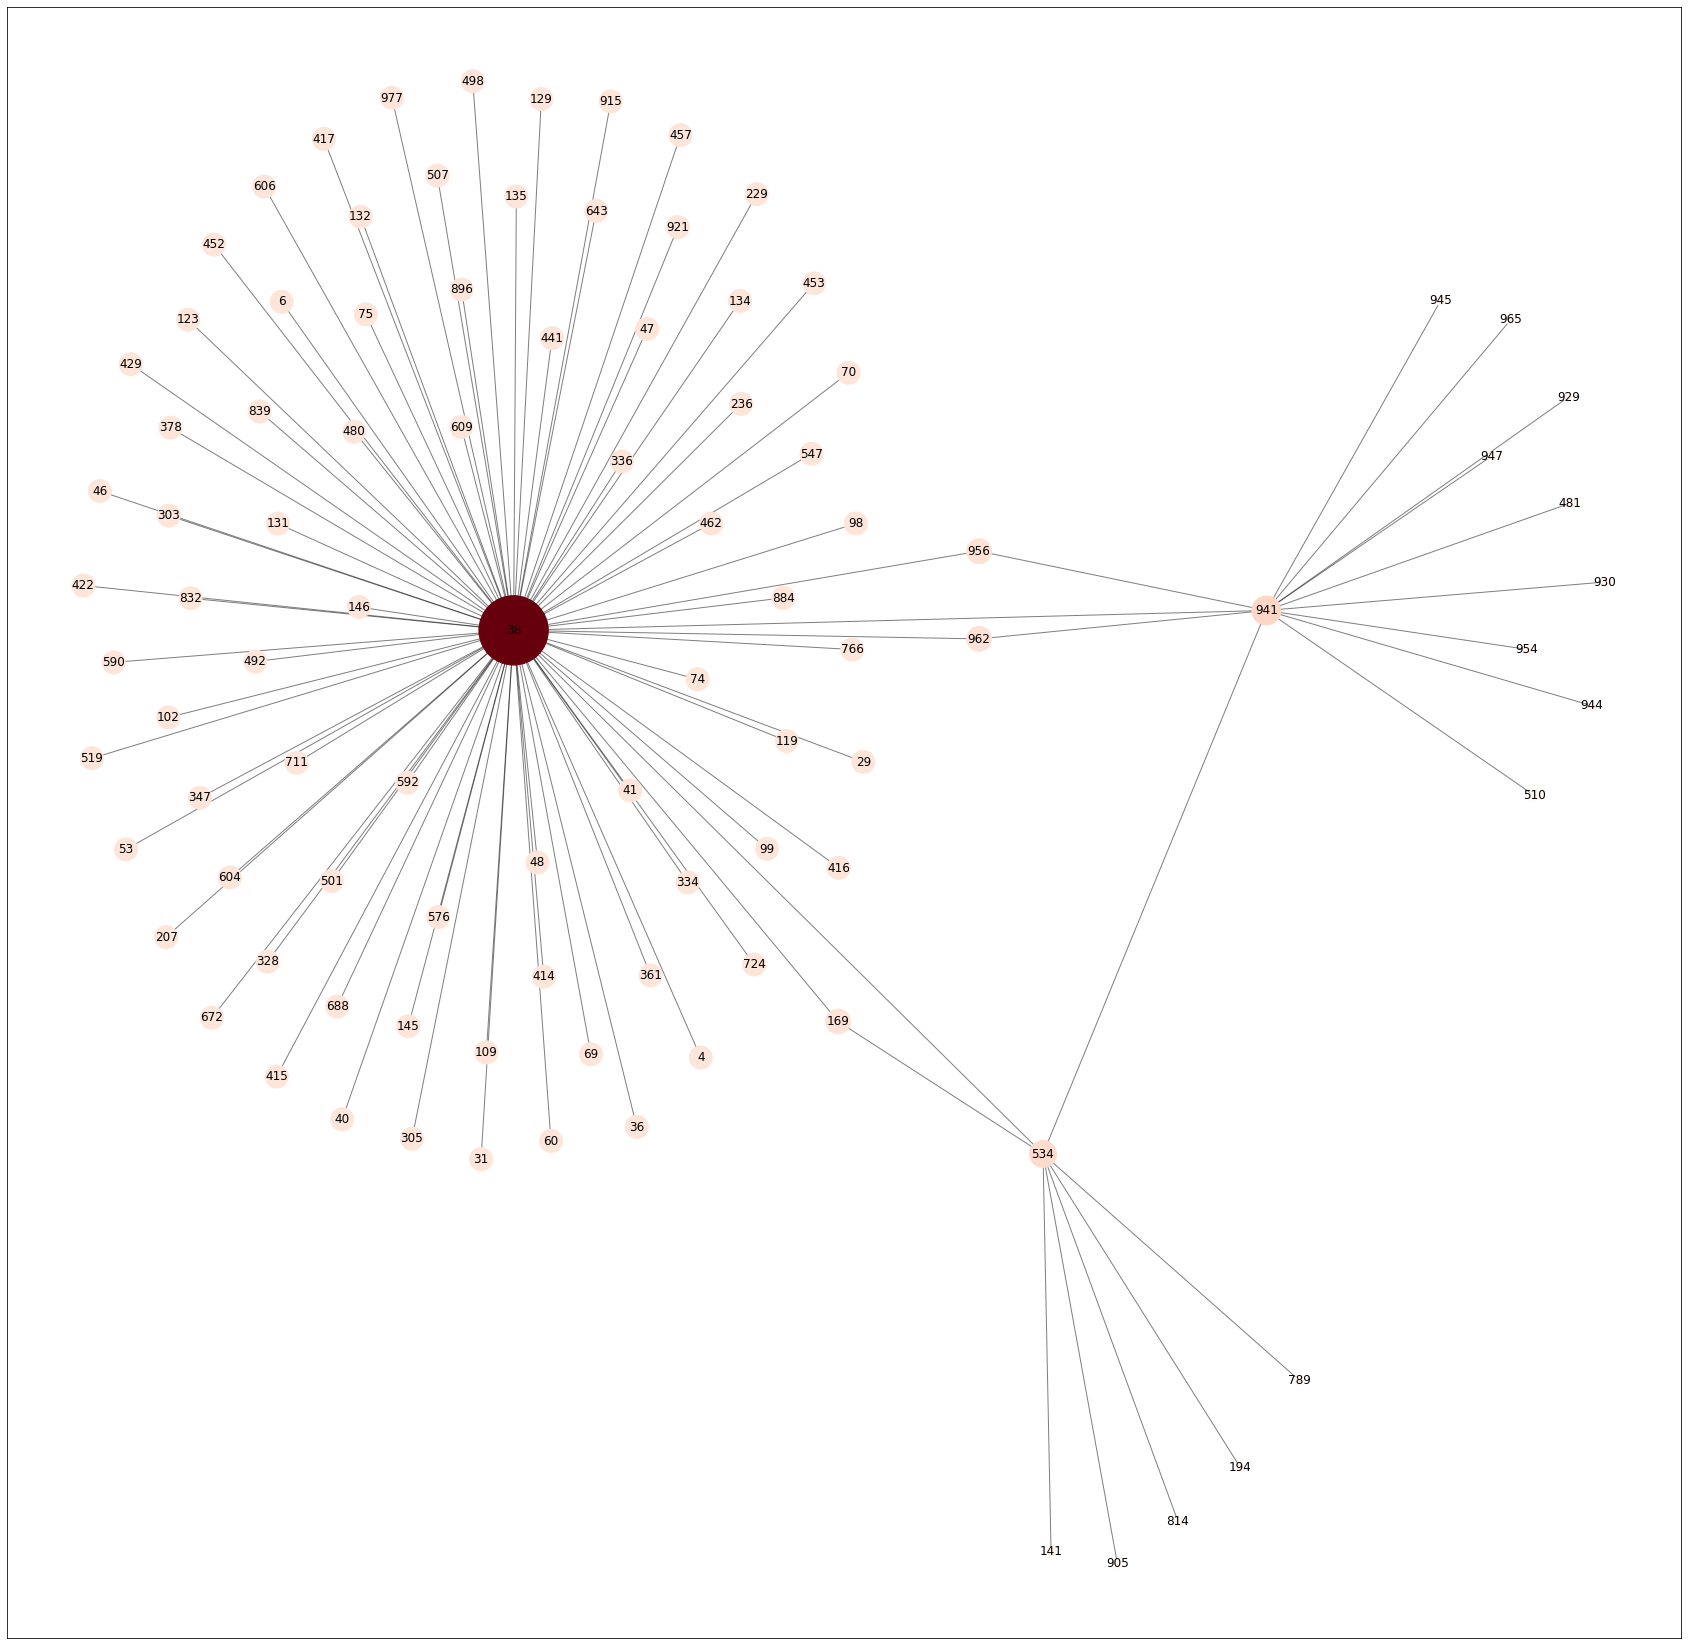

In [53]:
# HITS Autorities
show_authority_weights(graph,authority_weights)

Louvain
Partition:
{38: 0, 956: 1, 962: 1, 941: 1, 74: 0, 36: 0, 53: 0, 48: 0, 29: 0, 46: 0, 40: 0, 60: 0, 31: 0, 41: 0, 6: 0, 4: 0, 547: 0, 832: 0, 129: 0, 915: 0, 921: 0, 507: 0, 501: 0, 839: 0, 99: 0, 452: 0, 457: 0, 453: 0, 131: 0, 462: 0, 416: 0, 414: 0, 417: 0, 415: 0, 109: 0, 119: 0, 70: 0, 361: 0, 604: 0, 69: 0, 422: 0, 47: 0, 378: 0, 643: 0, 592: 0, 576: 0, 606: 0, 724: 0, 672: 0, 711: 0, 609: 0, 590: 0, 305: 0, 441: 0, 519: 0, 480: 0, 498: 0, 896: 0, 236: 0, 134: 0, 132: 0, 429: 0, 146: 0, 145: 0, 98: 0, 169: 2, 102: 0, 123: 0, 766: 0, 492: 0, 229: 0, 328: 0, 207: 0, 334: 0, 534: 2, 347: 0, 303: 0, 977: 0, 75: 0, 884: 0, 336: 0, 688: 0, 135: 0, 141: 2, 905: 2, 789: 2, 814: 2, 194: 2, 481: 1, 510: 1, 954: 1, 965: 1, 929: 1, 930: 1, 947: 1, 945: 1, 944: 1}


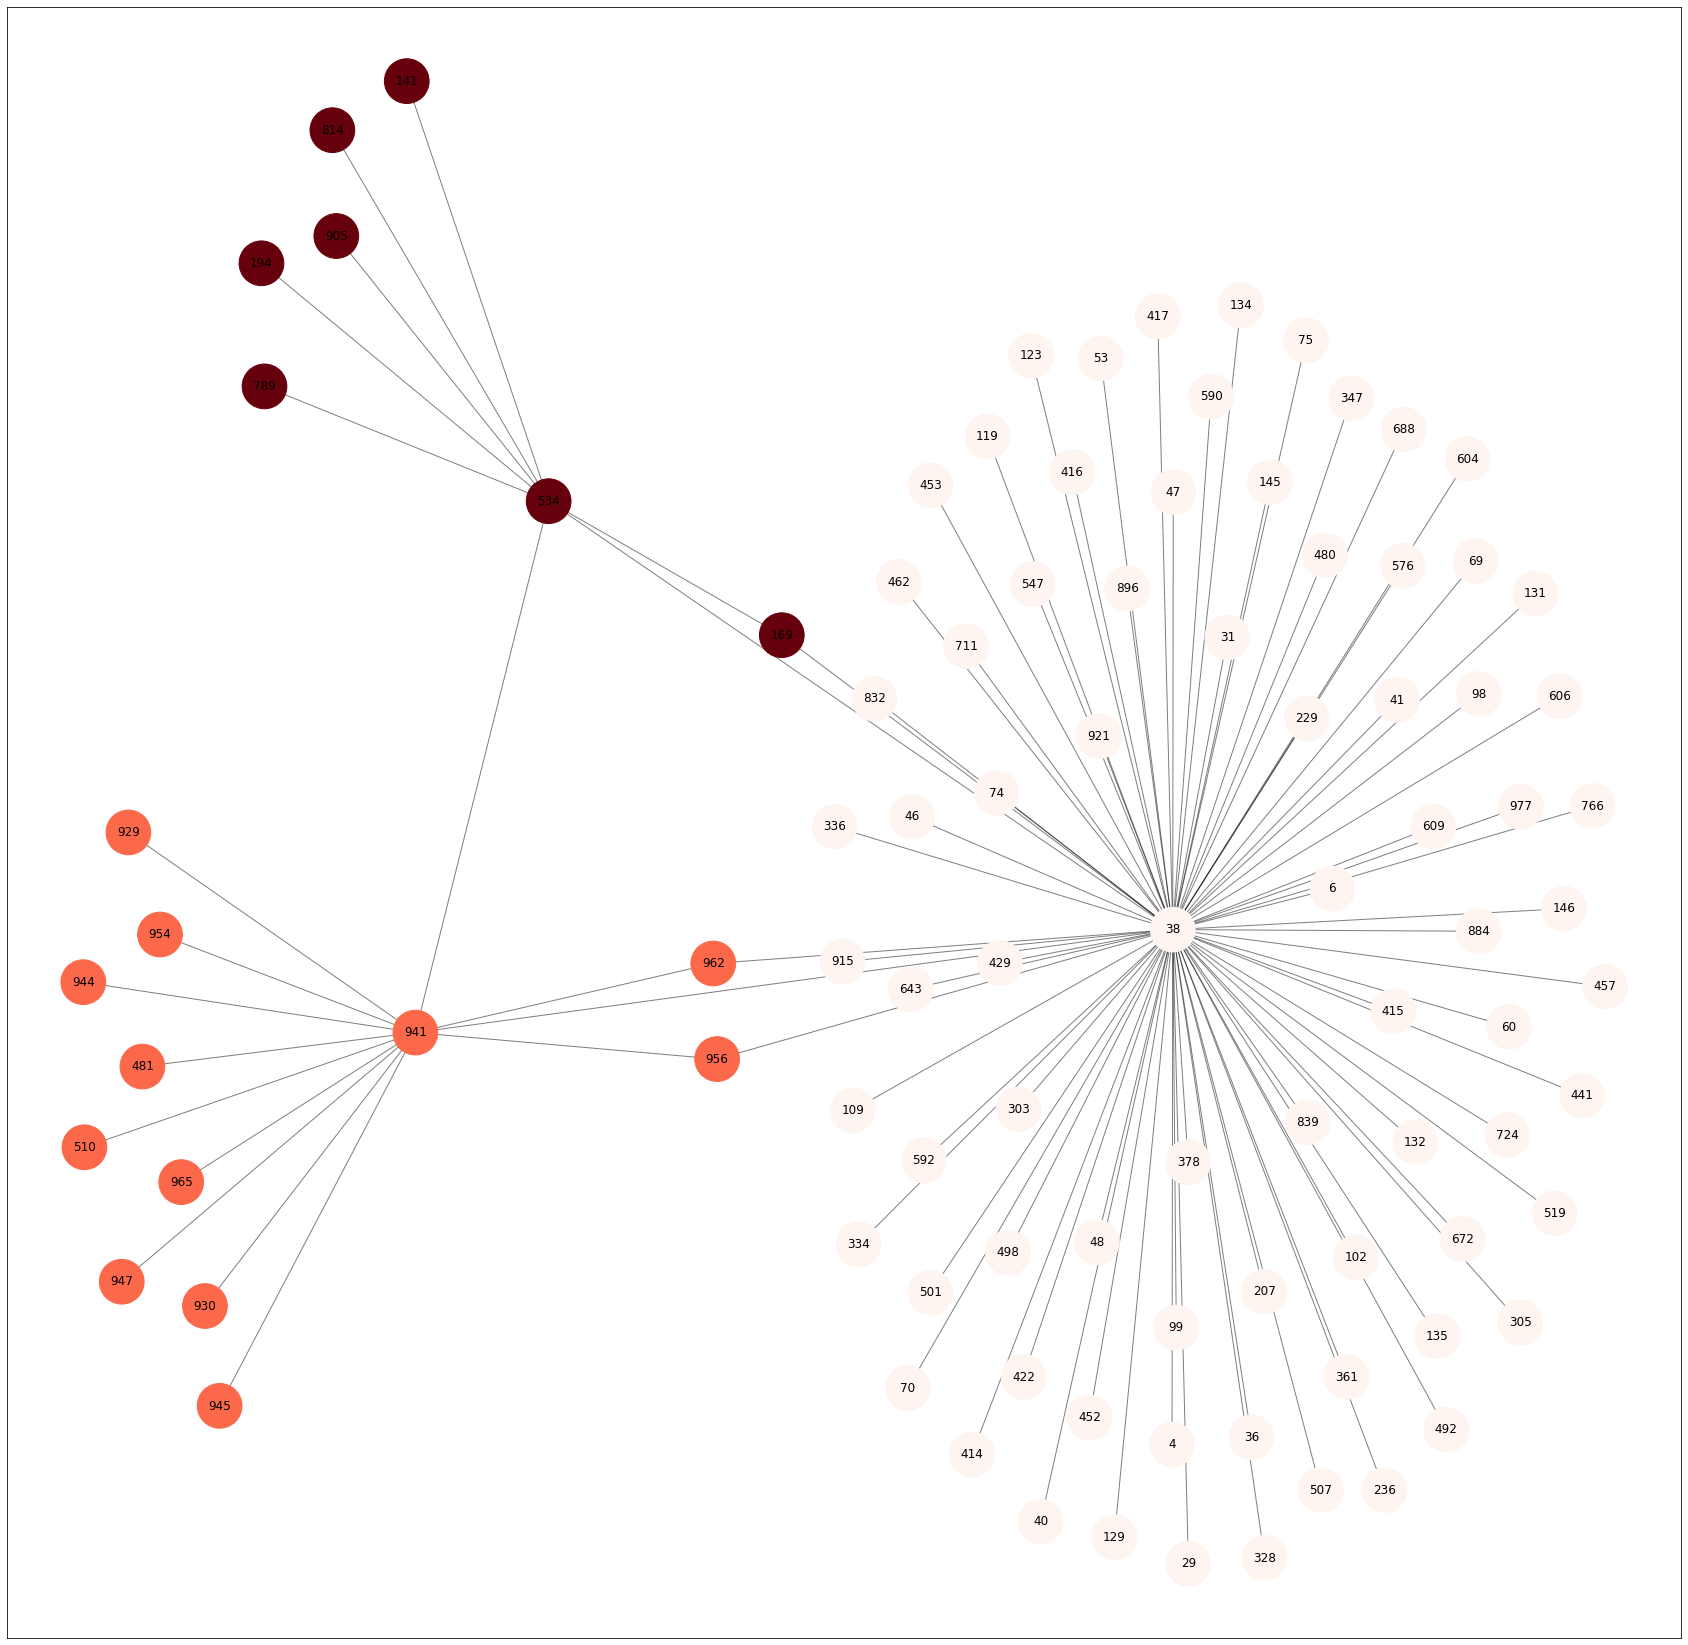

In [54]:
# Louvain algorithm
louvain(graph)

Leiden
Partition: {38: 0, 74: 0, 36: 0, 53: 0, 48: 0, 29: 0, 46: 0, 40: 0, 60: 0, 31: 0, 41: 0, 6: 0, 4: 0, 547: 0, 832: 0, 129: 0, 915: 0, 921: 0, 507: 0, 501: 0, 839: 0, 99: 0, 452: 0, 457: 0, 453: 0, 131: 0, 462: 0, 416: 0, 414: 0, 417: 0, 415: 0, 109: 0, 119: 0, 70: 0, 361: 0, 604: 0, 69: 0, 422: 0, 47: 0, 378: 0, 643: 0, 592: 0, 576: 0, 606: 0, 724: 0, 672: 0, 711: 0, 609: 0, 590: 0, 305: 0, 441: 0, 519: 0, 480: 0, 498: 0, 896: 0, 236: 0, 134: 0, 132: 0, 429: 0, 146: 0, 145: 0, 98: 0, 102: 0, 123: 0, 766: 0, 492: 0, 229: 0, 328: 0, 207: 0, 334: 0, 347: 0, 303: 0, 977: 0, 75: 0, 884: 0, 336: 0, 688: 0, 135: 0, 956: 1, 962: 1, 941: 1, 481: 1, 510: 1, 954: 1, 965: 1, 929: 1, 930: 1, 947: 1, 945: 1, 944: 1, 169: 2, 534: 2, 141: 2, 905: 2, 789: 2, 814: 2, 194: 2}


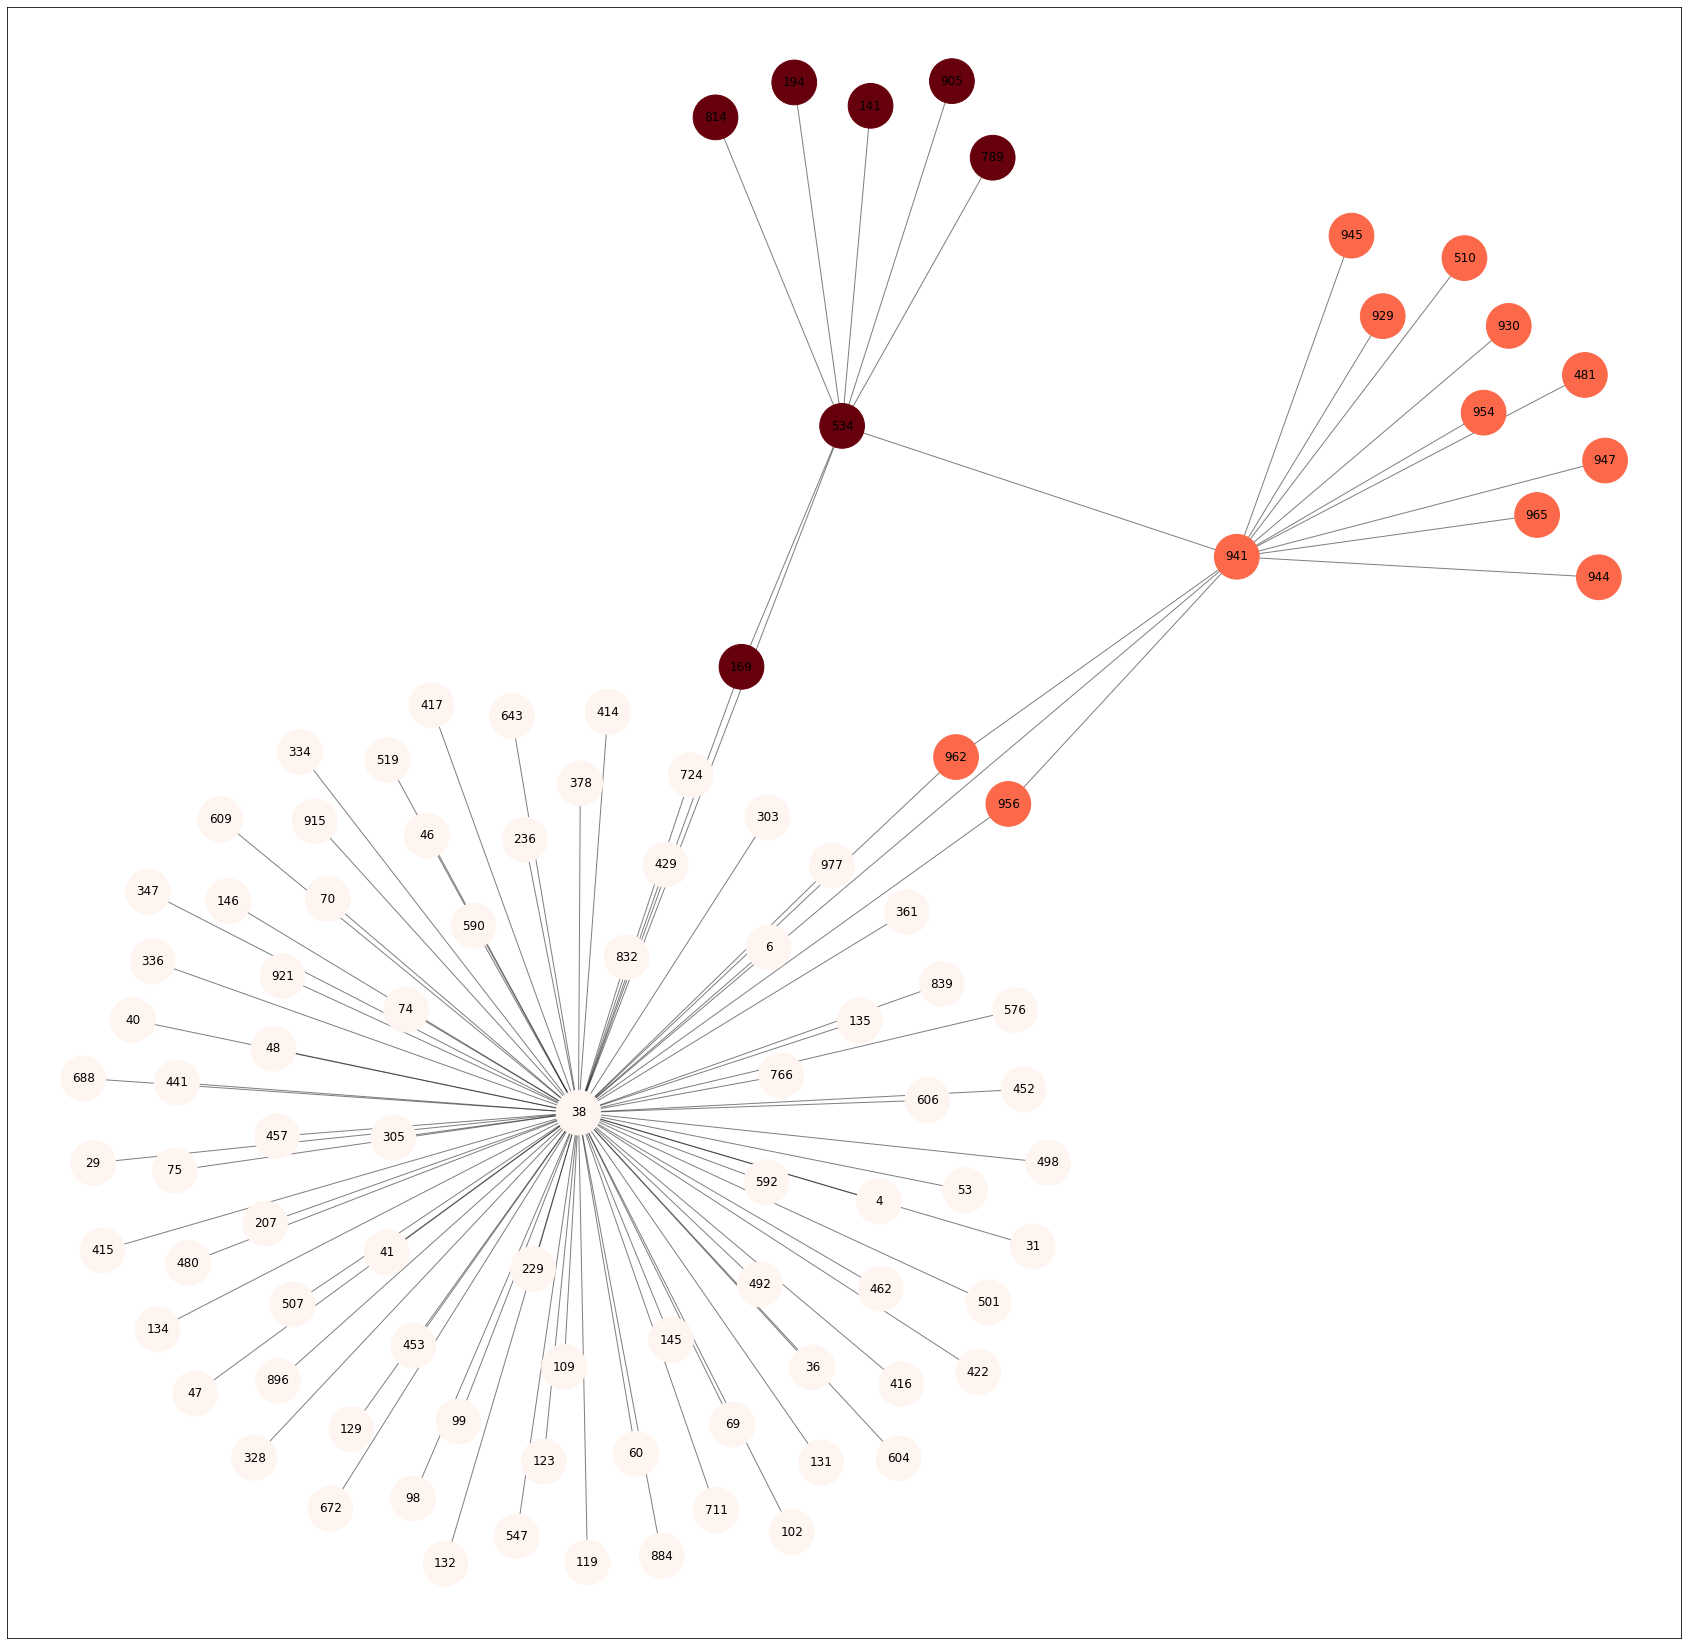

In [55]:
# Leiden algorithm
leiden(graph)